# LoFi

In this demo, we take Diagonal LoFi for the 1d-regression problem in continual learning and compare the peformance of the method when using Fourier features v.s. not using Fourier features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
from typing import Callable
import matplotlib.pyplot as plt
from functools import partial
from jax.flatten_util import ravel_pytree

In [3]:
from rebayes import base
from rebayes.utils.preprocessing import fourier_basis
from rebayes.low_rank_filter import lofi
from rebayes.utils import nonstat_1d_data as datagen
from rebayes.utils.utils import get_subtree, tree_to_cpu

In [4]:
%config InlineBackend.figure_format = "retina"

## Dataset

In [108]:
key = jax.random.PRNGKey(3141)
key_data, key_basis = jax.random.split(key)
n_dist = 6
n_train = 100
data_flat, data_tasks = datagen.sample_1d_regression_sequence(key, n_dist, n_train=n_train)


num_basis, input_dim = 6, 1
b = jax.random.normal(key_basis, (num_basis, input_dim)) * 0.3
jax.tree_map(jnp.shape, data_tasks)



{'eval': {'X': (6, 500), 'y': (6, 500)},
 'test': {'X': (6, 100, 1), 'y': (6, 100, 1)},
 'train': {'X': (6, 100, 1), 'y': (6, 100, 1)}}

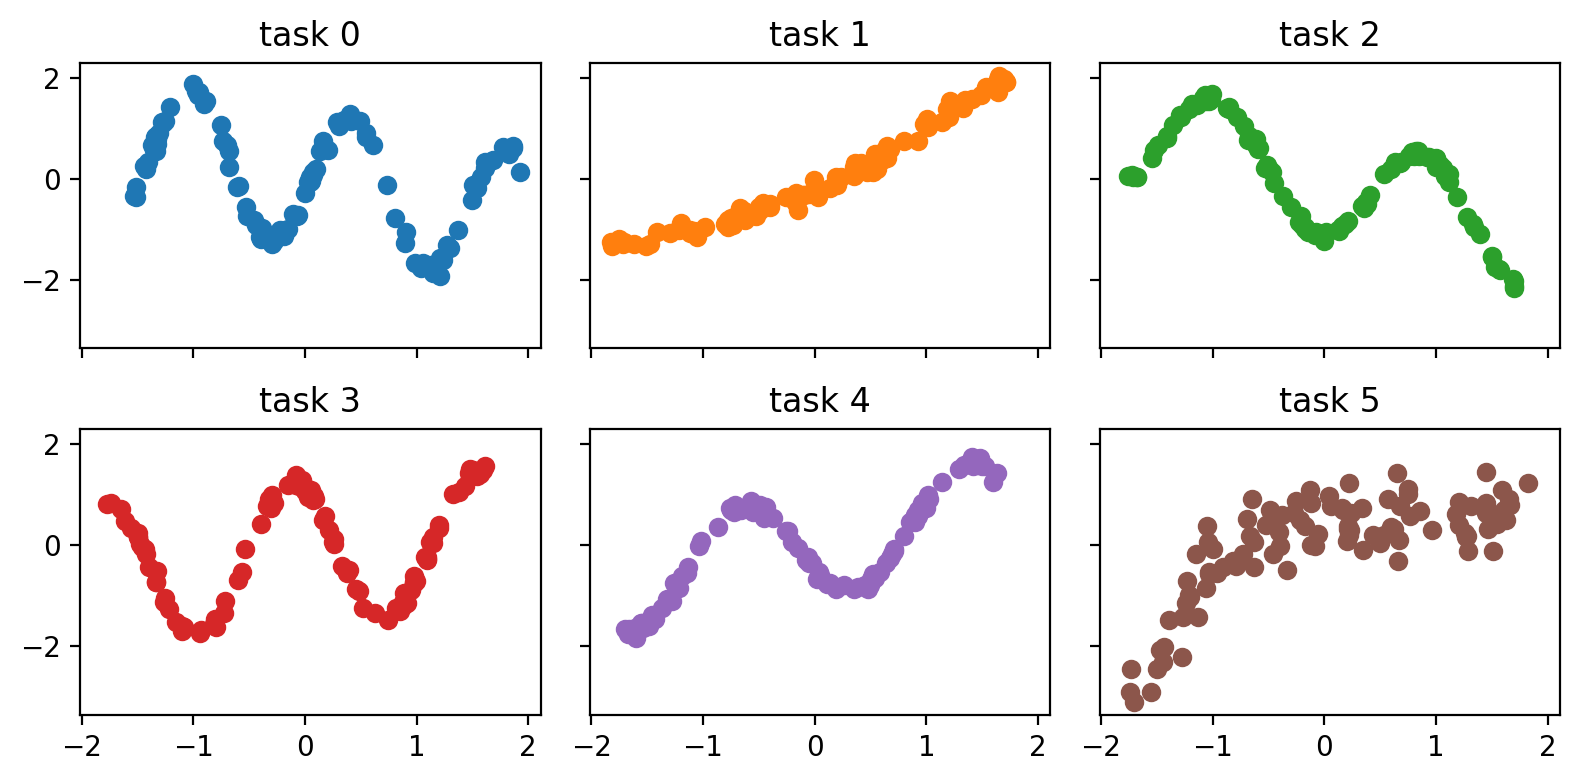

In [115]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4), sharex=True, sharey=True)

colors = plt.cm.tab10(np.arange(n_dist))
for n, ax in enumerate(axs.ravel()):
    data_slice = datagen.slice_tasks(data_flat, n)
    c=colors[n]
    ax.scatter(data_slice["train"]["X"], data_slice["train"]["y"], color=c)
    ax.set_title(f"task {n}")
plt.tight_layout()

In [116]:
X_train_seq = data_flat["train"]["X"]
X_train_seq_fourier = fourier_basis(X_train_seq, b)
Y_train_seq = data_flat["train"]["y"]
train_id_seq = data_flat["train"]["id_seq"]

X_test_seq = data_flat["test"]["X"]
X_test_seq_fourier = fourier_basis(X_test_seq, b)
Y_test_seq = data_flat["test"]["y"]
test_id_set = data_flat["test"]["id_seq"]


X_test_tasks_flat = data_tasks["test"]["X"]
X_test_tasks_fourier = fourier_basis(X_test_tasks_flat, b)
Y_test_tasks = data_tasks["test"]["y"]

X_train_tasks_flat = data_tasks["train"]["X"]
X_train_tasks_fourier = fourier_basis(X_train_tasks_flat, b)
Y_train_tasks = data_tasks["train"]["y"]

## Setup 

In [117]:
class MLP(nn.Module):
    n_out: int
    n_hidden: int
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
def make_bnn_flax(dim_in, nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

In [118]:
ntest = 100
xtest_ravel = jnp.linspace(-2.0, 2.0, num=ntest)[:, None]
xtest_ravel_fourier = fourier_basis(xtest_ravel, b)

In [119]:
n_samples = 55
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, apply_fn, X_test, Y_test, xeval, **kwargs):
    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test[task]).squeeze()
    ytrue = Y_test[task].squeeze()
    
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))
    
    key_step = jax.random.fold_in(key, t)
    yhat_samples = agent.pred_obs_mc(key_step, bel, xeval, shape=(n_samples,))

    out = {
        'rmse_test_current_task': rmse_test_current_task,
        'mae_test_current_task': mae_test_current_task,
        'pred_test_current_task': yhat,
        "pp_samples": yhat_samples,
           }
    
    return out

# Fit

In [120]:
base_ssm_params = base.RebayesParams(
        initial_mean=None,
        initial_covariance=0.01, # 0.06
        dynamics_weights=1,
        dynamics_covariance=1e-7,#1e-6,
        emission_mean_function=None,
        emission_cov_function = lambda w,x: 0.02,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=0.001,
)

mem = 10
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False)

In [121]:
collection_agents = {}
collection_outputs = {}

## Flat

In [122]:
_, dim_in = X_train_seq.shape
model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in)

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

ssm_params = base_ssm_params.replace(
    initial_mean=flat_params,
    emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn)
)

agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

callback_part = partial(callback,
                        X_test=X_test_tasks_flat,
                        Y_test=Y_test_tasks,
                        apply_fn=agent.params.emission_mean_function,
                        xeval=xtest_ravel,
                       )

bel, outputs = agent.scan(X_train_seq, Y_train_seq, callback=callback_part, progress_bar=True)
bel = jax.block_until_ready(bel)

method = "flat"
collection_agents[method] = agent
collection_outputs[method] = outputs

  0%|          | 0/600 [00:00<?, ?it/s]

## Fourier

In [123]:
_, dim_in = X_train_seq_fourier.shape
model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in)

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

ssm_params = base_ssm_params.replace(
    initial_mean=flat_params,
    emission_mean_function=partial(apply_fn_flat, model=model, recfn=recfn)
)

agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

callback_part = partial(callback,
                        X_test=X_test_tasks_fourier,
                        Y_test=Y_test_tasks,
                        apply_fn=agent.params.emission_mean_function,
                        xeval=xtest_ravel_fourier,
                       )

bel, outputs = agent.scan(X_train_seq_fourier, Y_train_seq, callback=callback_part, progress_bar=True)
bel = jax.block_until_ready(bel)


method = "fourier"
collection_agents[method] = agent
collection_outputs[method] = outputs

  0%|          | 0/600 [00:00<?, ?it/s]

# Eval

In [124]:
keyv = "rmse_test_current_task"
metrics = tree_to_cpu(get_subtree(collection_outputs, keyv))

Text(0.5, 1.0, 'RMSE on current task')

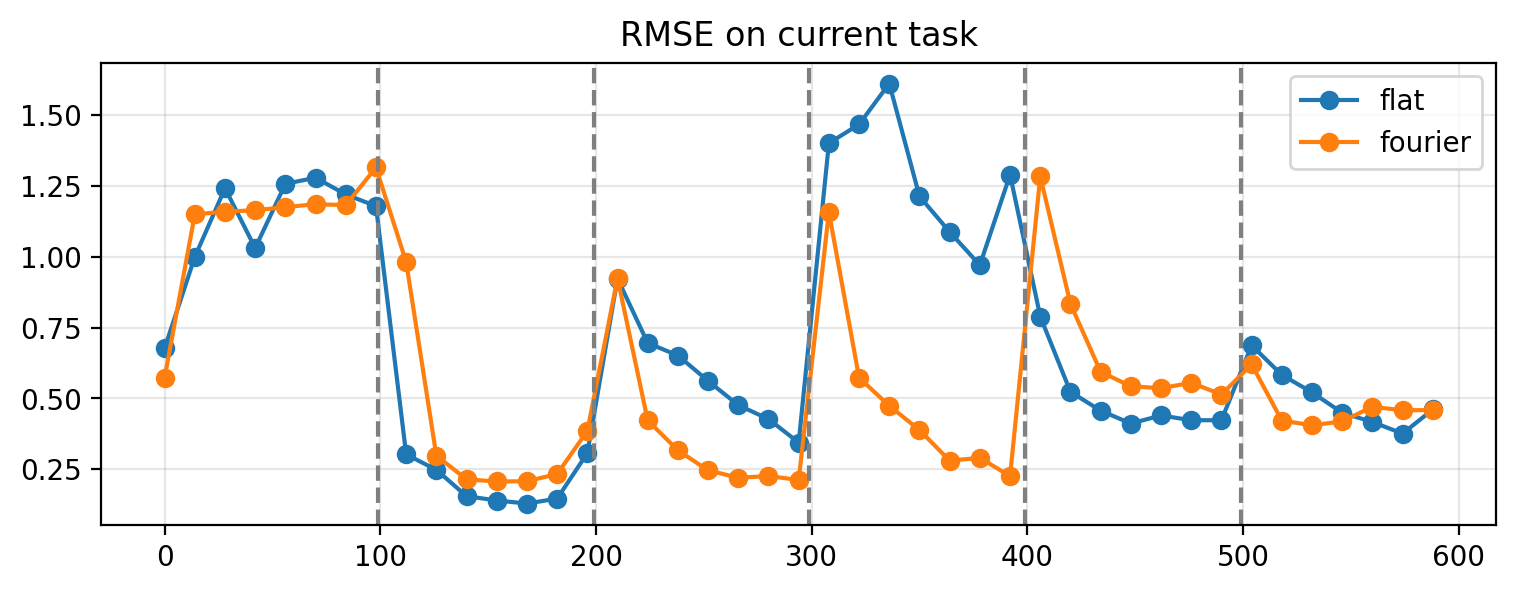

In [125]:
ksize = 10
kernel = jnp.ones(ksize) / ksize
changepoints = np.arange(n_train, n_dist * n_train, step=n_train) - 1

fig, ax = plt.subplots(figsize=(9, 3))
for method in metrics:
    hist_err = jnp.convolve(metrics[method], kernel, mode="same")
    ndata = len(hist_err)
    ndx = jnp.arange(0, ndata, step=14)
    ax.plot(ndx, hist_err[ndx], marker="o", label=method)

for c in changepoints:
    ax.axvline(x=c, color="tab:gray", linestyle="--")

plt.legend()
plt.grid(alpha=0.3)
plt.title("RMSE on current task")

## Comparisson posterior mean

In [126]:
def reshape_task(x):
    _, *shape = x.shape
    new_shape = (n_dist, -1, *shape)
    return x.reshape(new_shape)

@partial(jax.vmap, in_axes=(None, 0, None, None, None))
@partial(jax.vmap, in_axes=(0, 0, None, None, None))
def xsample(key, bel, agent, x, n_samples):
    # x = fourier_basis(x, b)
    yhat_samples = agent.pred_obs_mc(key, bel, x, shape=(n_samples,))
    return yhat_samples

In [127]:
key = jax.random.PRNGKey(3141)

In [128]:
collection_pp_samples = get_subtree(collection_outputs, "pp_samples")
collection_pp_samples = tree_to_cpu(collection_pp_samples)
collection_pp_samples = jax.tree_map(reshape_task, collection_pp_samples)
jax.tree_map(jnp.shape, collection_pp_samples)

{'flat': (6, 100, 55, 100, 1), 'fourier': (6, 100, 55, 100, 1)}

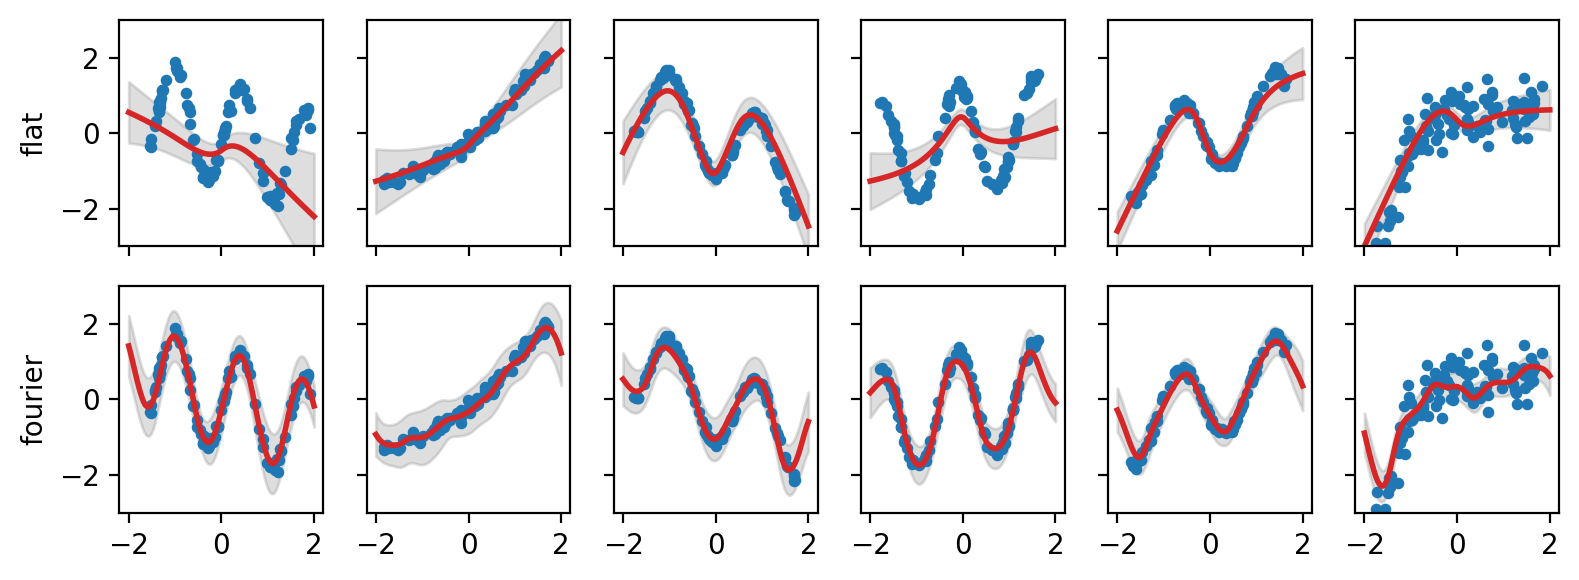

In [129]:
fig, axs_collection = plt.subplots(2, n_dist, figsize=(8, 3), sharex=True, sharey=True)

ix_eval = 99
for method, axs in zip(collection_pp_samples, axs_collection):
    for task, ax in enumerate(axs.ravel()):
        yhat_samples = collection_pp_samples[method][task, ix_eval, ...].squeeze()
        yhat_mean = yhat_samples.mean(axis=0)
        yhat_std = yhat_samples.std(axis=0)
        
        ylb = yhat_mean - 2 * yhat_std
        yub = yhat_mean + 2 * yhat_std
    
        ax.fill_between(xtest_ravel.ravel(), ylb, yub, color="tab:gray", linewidth=1, alpha=0.25)

#         for yhat in yhat_samples:
#             ax.plot(xtest_ravel, yhat, c="tab:gray", linewidth=1, alpha=0.25)
        
        ax.plot(xtest_ravel, yhat_mean, c="tab:red", linewidth=2)
        ax.scatter(X_train_tasks_flat[task, :ix_eval], Y_train_tasks[task, :ix_eval], s=10)
        ax.set_ylim(-3, 3)

axs_collection[0, 0].set_ylabel("flat")
axs_collection[1, 0].set_ylabel("fourier")
plt.tight_layout()

## comicstrip

In [130]:
collection_pp_samples = get_subtree(collection_outputs, "pp_samples")
collection_pp_samples = tree_to_cpu(collection_pp_samples)
jax.tree_map(jnp.shape, collection_pp_samples)

{'flat': (600, 55, 100, 1), 'fourier': (600, 55, 100, 1)}

In [131]:
xtest_ravel.shape # fixed
X_train_seq.shape
Y_train_seq.shape

(600, 1)

In [132]:
n_tot = 3 * n_train - 1
n_frames = 17
ix_frames = np.linspace(0, n_tot, n_frames).round().astype(int)

In [133]:
xtest_ravel_np = np.array(xtest_ravel).squeeze()

In [134]:
colors = ["tab:green", "tab:purple", "tab:olive"]

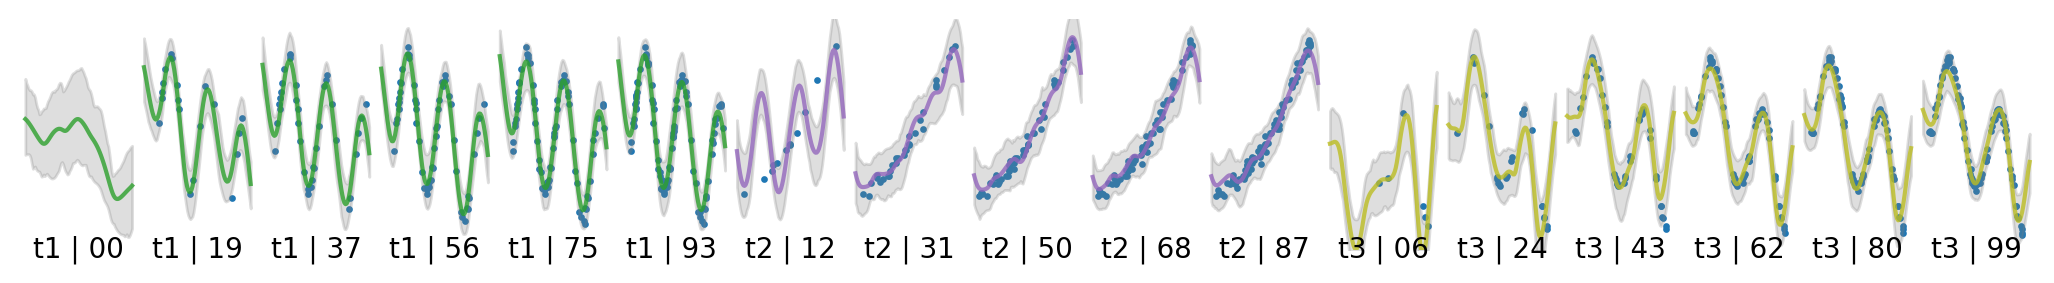

In [135]:
gridspec_kw = {"hspace": 0.0, "wspace": 0.01}
fig, axs = plt.subplots(1, n_frames, figsize=(13, 1.5), sharex=True, sharey=True, gridspec_kw=gridspec_kw)

for ix, ax in zip(ix_frames, axs):
    
    num_obs = ix % n_train
    task = ix // n_train
    nmin = task * n_train
    
    yhat_samples = collection_pp_samples["fourier"][ix].squeeze()
    
    yhat_mean = yhat_samples.mean(axis=0)
        
    ax.scatter(X_train_seq[nmin:ix], Y_train_seq[nmin:ix], s=2)
    
    c = colors[task]
    ax.plot(xtest_ravel_np, yhat_mean, c=c, linewidth=1.5, alpha=0.8)
    ax.axis("off")
    
    yhat_lb = np.quantile(yhat_samples, axis=0, q=0.05)
    yhat_ub = np.quantile(yhat_samples, axis=0, q=0.95)
    
    ax.fill_between(xtest_ravel_np, yhat_lb, yhat_ub, color="tab:gray", alpha=0.25)
    
    # for sample in yhat_samples[:10]:
    #     ax.plot(xtest_ravel_np, sample, c="tab:gray", alpha=0.2, linewidth=1)
        
    ax.set_ylim(-2.5, 2.5)
    ax.set_title(f"t{task + 1} | {num_obs:02}", y=-0.1, fontsize=10)
    # ax.axis("equal")
# plt.savefig("./figures/flipbook-lofi-fourier.png", dpi=300)

## Stripplot v.2.

In [136]:
n_tot = 3 * n_train - 1
n_frames = 10
ix_frames = np.linspace(0, n_train - 1, n_frames).round().astype(int)

In [137]:
xtest_ravel_np = np.array(xtest_ravel).squeeze()

In [138]:
colors = ["tab:green", "tab:purple", "tab:olive", "tab:orange", "tab:blue"]

In [140]:
x_eval = np.array(data_tasks["eval"]["X"])
y_eval = np.array(data_tasks["eval"]["y"])

In [152]:
pos_vals = ["top", "right", "bottom", "left"]



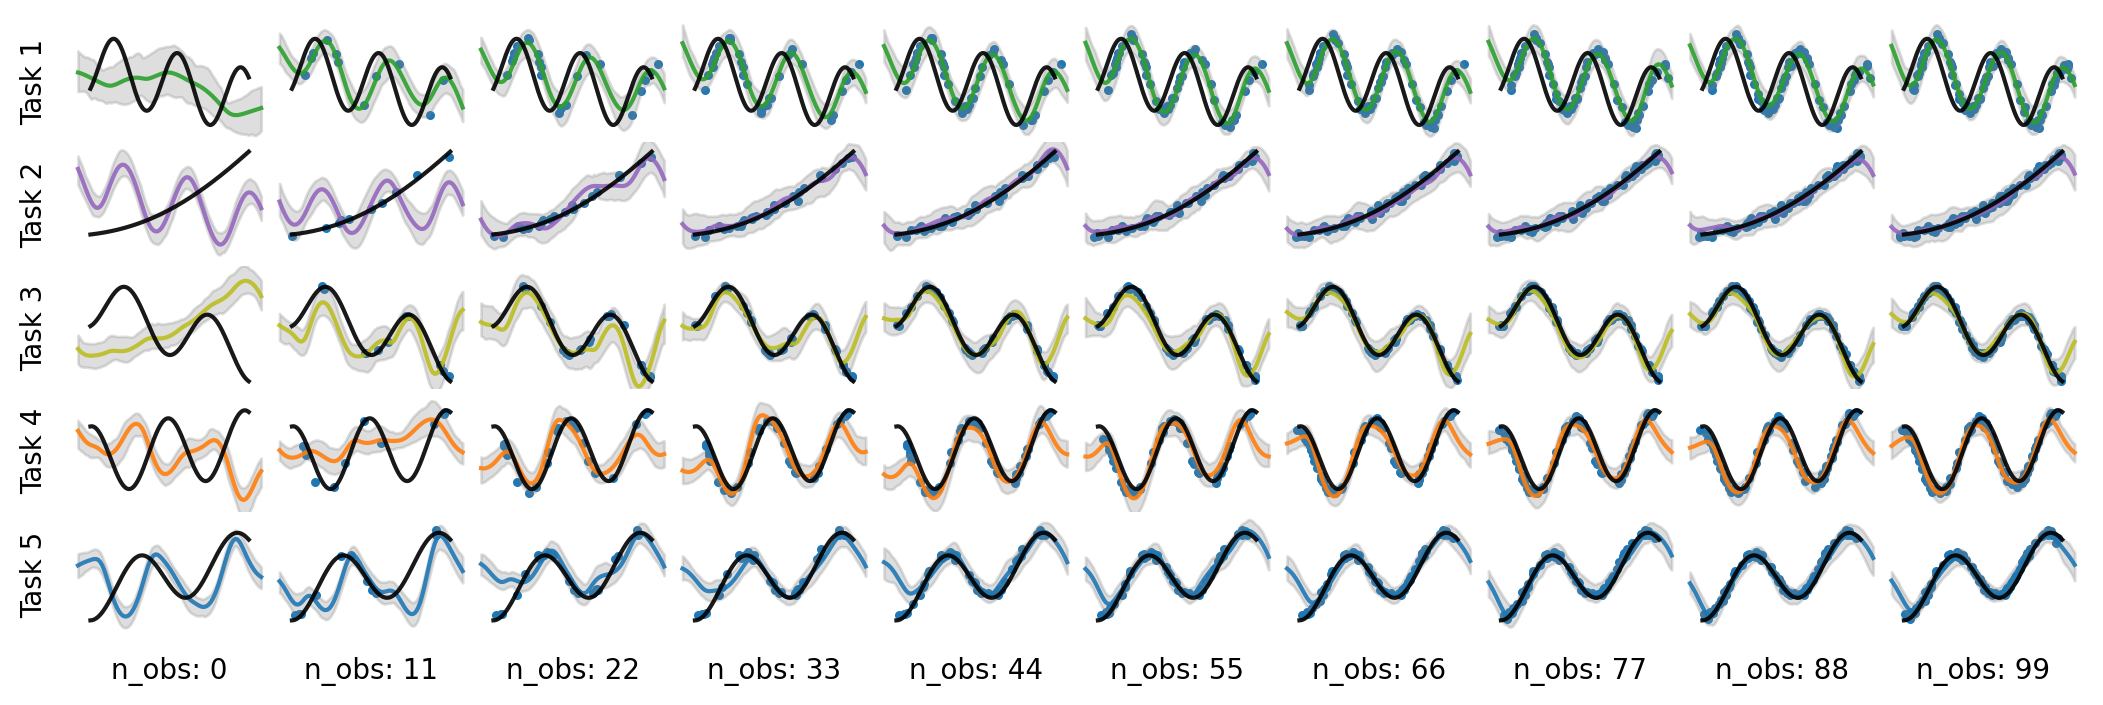

In [160]:
gridspec_kw = {"hspace": 0.0, "wspace": 0.0}

ntasks_sub = 5
fig, axs_grid = plt.subplots(ntasks_sub, n_frames, figsize=(13, 4), sharex=True, sharey=True, gridspec_kw=gridspec_kw)

yhat_samples_all = einops.rearrange(
    collection_pp_samples["fourier"].squeeze(),
    "(n_tasks n_obs) ... -> n_tasks n_obs ...",
    n_tasks=n_dist
)

x_train_tasks = np.array(X_train_tasks_flat).squeeze()
y_train_tasks = np.array(Y_train_tasks.squeeze())

for task, (axs, color) in enumerate(zip(axs_grid, colors)):
    for ax, ix in zip(axs, ix_frames):
    
        yhat_samples = yhat_samples_all[task, ix]
        yhat_mean = yhat_samples.mean(axis=0)

        ax.scatter(x_train_tasks[task, :ix], y_train_tasks[task, :ix], s=5)

        c = colors[task]
        ax.plot(xtest_ravel_np, yhat_mean, c=c, linewidth=1.5, alpha=0.9)

        yhat_lb = np.quantile(yhat_samples, axis=0, q=0.05)
        yhat_ub = np.quantile(yhat_samples, axis=0, q=0.95)

        ax.fill_between(xtest_ravel_np, yhat_lb, yhat_ub, color="tab:gray", alpha=0.25)
        ax.plot(x_eval[task], y_eval[task], c="black", alpha=0.9)

        ax.set_ylim(-2.5, 2.5)
        
        for pos in pos_vals:
            ax.spines[pos].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    
for i, ax in enumerate(axs_grid[:, 0]):
    ax.set_ylabel(f"Task {i + 1}")

for ix, ax in zip(ix_frames, axs_grid[-1, :]):
    ax.set_xlabel(f"n_obs: {ix}")
    
plt.savefig("./figures/flipbook-lofi-fourier-grid.png", dpi=300)

## An animation

In [30]:
import numpy as np
from matplotlib.animation import FuncAnimation

In [31]:
X_test_tasks_flat = np.array(X_test_tasks_flat)
Y_test_tasks = np.array(Y_test_tasks)
yhat_xmap = np.array(yhat_xmap)
xtest_ravel = np.array(xtest_ravel)

CPU times: user 2min 15s, sys: 4.32 s, total: 2min 19s
Wall time: 2min 4s


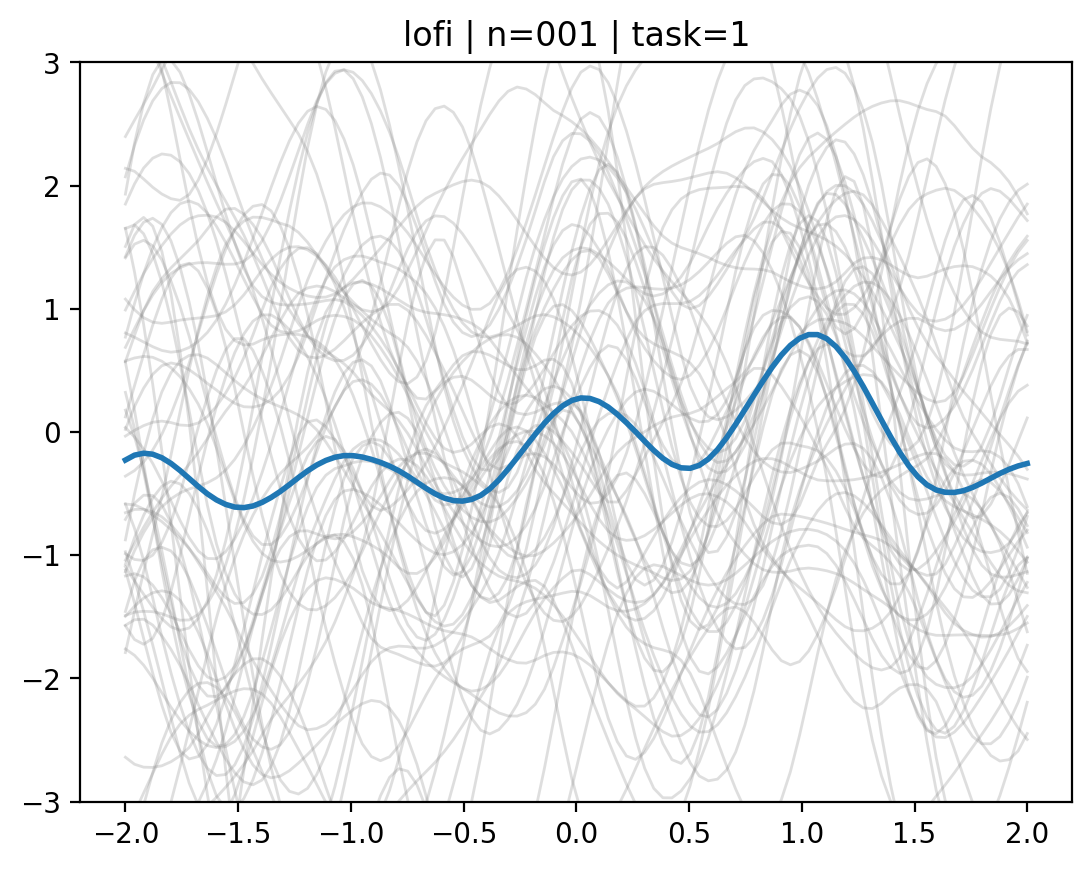

In [39]:
%%time
fig, ax = plt.subplots()

label = "lofi"

nmin = 0
def update(ix):
    
    num_obs = ix % n_train
    task = ix // n_train
    
    xtest = X_test_tasks_flat[task][:num_obs]
    
    ax.cla()
    yhat_samples = yhat_xmap[task, num_obs, ...]
    yhat_mean = yhat_samples.mean(axis=0)

    for yhat in yhat_samples:
        ax.plot(xtest_ravel, yhat, c="tab:gray", linewidth=1, alpha=0.25)
    ax.plot(xtest_ravel, yhat_mean, c="tab:blue", linewidth=2)

    xtest = X_train_tasks_flat[task][nmin:num_obs]
    ytrue = Y_train_tasks[task].ravel()[nmin:num_obs]
    ax.scatter(xtest, ytrue, facecolors="none", edgecolors="tab:gray")
    
    if len(xtest) > 0:
        ax.scatter(xtest[-1], ytrue[-1], c="tab:red")

    ax.set_ylim(-3, 3)
    ax.set_title(f"{label} | n={num_obs+1:03} | task={task+1}")
    
frames = np.arange(n_dist * n_train)
ani = FuncAnimation(fig, update, frames=frames)
ani.save("./figures/lofi-posterior-predictive-fourier.mp4", dpi=100, bitrate=-1, fps=10)